In [1]:
import time
import numpy as np
import scipy as sp
import scipy.ndimage
import os
from IPython.display import display, clear_output, HTML
import sys

sys.path.append('../motion_clouds/')
from mcClass import *
import matplotlib.pyplot as plt
from matplotlib import animation
animation.rcParams['animation.writer']='ffmpeg'

%matplotlib inline



In [2]:
N = 128
fM = 2.0
fS = 1.0
octa = 1
th = 0
thS = 2.5
fT = 1.0/0.3
v = np.array([1.0,1.0])
MC = np.zeros((24), dtype=object)

i=0
for th in np.linspace(0,345,24):
    v = 1.0*np.array([np.cos(th),np.sin(th)])
    MC[i] = motionCloud(overSamp=2, N=N, chooseDev=0, show=0)
    MC[i].mcKernel(fM, fS, th, thS, fT, v, octa)
    MC[i].initGPU()
    i+=1


C:\Anaconda2\lib\site-packages\pyopencl\__init__.py:63: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


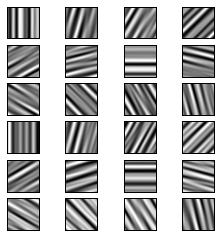

In [3]:
fig1, axes1 = plt.subplots(nrows=6, ncols=4,figsize=(4, 4))

i=0
for k in range(6):
    for l in range(4):    
        axes1[k,l].imshow(MC[i].getFrame(), cmap='gray')
        axes1[k,l].xaxis.set_visible(False)
        axes1[k,l].yaxis.set_visible(False)

        i+=1

$$\begin{align}
    f(x,y) &=
      \frac{1}{2 \pi  \sigma_X \sigma_Y \sqrt{1-\rho^2}}
      \exp\left(
        -\frac{1}{2(1-\rho^2)}\left[
          \frac{(x-\mu_X)^2}{\sigma_X^2} +
          \frac{(y-\mu_Y)^2}{\sigma_Y^2} -
          \frac{2\rho(x-\mu_X)(y-\mu_Y)}{\sigma_X \sigma_Y}
        \right]
      \right)\\
\end{align}$$

In [95]:
# design the receptive field (RF) of neurons
isoOri = 0

x = np.linspace(-0.5,0.5,N)
X,Y = np.meshgrid(x,x)

RF = lambda((g,th,sx,sy,rho,a,x,y)): g*np.exp(-1.0/(2.0*(1.0-rho**2))\
    *( (x*np.cos(th)+y*np.sin(th))**2/sx**2 + (-x*np.sin(th)+y*np.cos(th))**2/sy**2 \
      - 2.0*rho*(x*np.cos(th)+y*np.sin(th))*(-x*np.sin(th)+y*np.cos(th))/(sx*sy) ) )\
    *np.cos(2.0*np.pi*a*(x*np.cos(th)+y*np.sin(th)))
    

sig = np.zeros(2)
sig[0] = 0.08
sig[1] = 0.2

msig = np.zeros(4)
msig[0]=0.5*0.08
msig[1]=0.75*0.08
msig[2]=1.0*0.08
msig[3]=2.0*0.08

a=fM*N/65.0 # spatial freq of RF
Neur = np.zeros((N,N,4))

if isoOri==1:
    thNeur = np.array([-np.pi/48,-np.pi/96,np.pi/96,np.pi/48,-np.pi/96,-np.pi/48,np.pi/48,np.pi/96])
else:
    #thNeur = np.array([0.0,np.pi/4,np.pi/2,3*np.pi/4,0.0,np.pi/4,np.pi/2,3*np.pi/4])
    thNeur = np.array([0.0,np.pi/2,0.0,np.pi/2])

k = 0
for i in range(4):
    Neur[:,:,i] = RF((1.0,thNeur[0],0.1,msig[i],0.0,a,X,Y))
    Neur[:,:,i] = Neur[:,:,i] - Neur[:,:,i].mean()
    if i==1:
        k=k+1

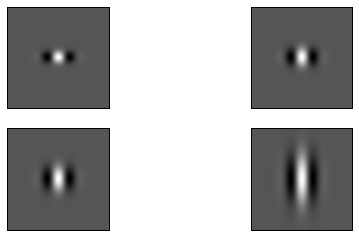

In [96]:
fig1, axes1 = plt.subplots(nrows=2, ncols=2,figsize=(8, 4))

i=0
for k in range(2):
    for l in range(2):
        axes1[k,l].imshow(Neur[:,:,i], cmap='gray');
        axes1[k,l].xaxis.set_visible(False)
        axes1[k,l].yaxis.set_visible(False)

        i+=1


In [97]:
#fig1.savefig('neurons.pdf', format='pdf', bbox_inches='tight') 

In [98]:
# simulate data

# residual firing rate (fr)
fr0 = 0.02
dur = 200 #(*10 ms)
stimOn = 50
stimOff = 150
neurons = Neur.shape[2]
conds = MC.shape[0]
reps = 5

b = np.zeros((dur*10,neurons,conds,reps))
f = np.zeros((dur*10,neurons,conds,reps))

for l in range(neurons):
    for k in range(reps):
        for j in range(conds):
            for i in range(dur):
                if (i>=stimOn) & (i<stimOff):
                    fr = fr0+np.absolute((np.sum(MC[j].getFrame()*Neur[:,:,l])>0)\
                                            *np.sum(MC[j].getFrame()*Neur[:,:,l]))/100000.0
                    b[10*i:10*(i+1),l,j,k]=np.random.poisson(fr,10)
                    f[10*i:10*(i+1),l,j,k]=fr*np.ones(10)
                else: 
                    fr = fr0
                    b[10*i:10*(i+1),l,j,k]=np.random.poisson(fr,10)
                    f[10*i:10*(i+1),l,j,k]=fr*np.ones(10)
            clear_output(wait=True)
            print 'Iteration: ', l, k, j
            sys.stdout.flush()
            
# remove multiple spikes that occur at the same time            
b[b>1]=1

Iteration:  3 4 23


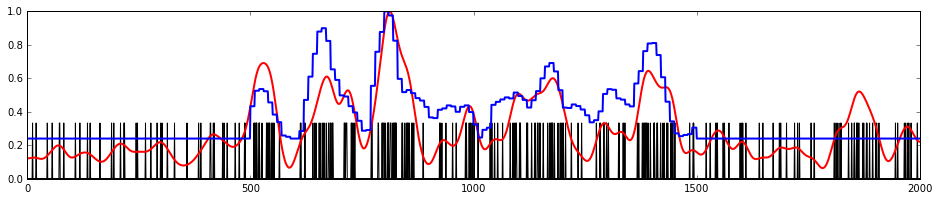

In [99]:
from scipy.ndimage.filters import *

fig0, axes0 = plt.subplots(nrows=1, ncols=1,figsize=(16,3));

interT = np.array(range(dur*10))
spik0 = b[:,0,0,:]#.mean(axis=1)
fire = f[:,0,0,:]
axes0.plot(interT, spik0/3, lw=1, color='k');
        
spik1 = gaussian_filter1d( spik0 , 15.0, axis=0 )
axes0.plot(interT, spik1.mean(axis=1)/spik1.mean(axis=1).max() , lw=2, color='r');
axes0.plot(interT, fire.mean(axis=1)/fire.mean(axis=1).max() , lw=2, color='b');

In [100]:
b.shape

(2000L, 4L, 24L, 5L)

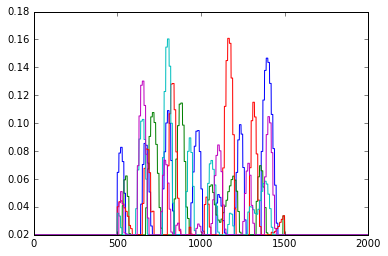

In [101]:
plt.plot(fire)

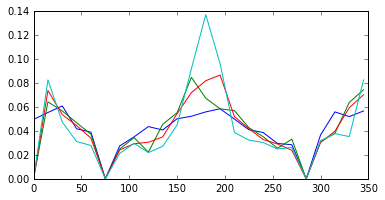

In [102]:
fig1, axes1 = plt.subplots(nrows=1, ncols=1,figsize=(6,3));

thTested = np.linspace(0,345,24)

tunCurve = b[500:1500,:,:,:].mean(axis=(0,3))

axes1.plot(thTested,tunCurve.T/tunCurve.sum(axis=1))

In [89]:
def objfun(g,mu,sig)

NameError: name 'gauss' is not defined